# Github Repository

In [4]:
!git clone "https://github.com/dani31v/Novordisk-Project.git"

Cloning into 'Novordisk-Project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [5]:
%cd Novordisk-Project/

/content/Novordisk-Project


In [6]:
!ls -la


total 16
drwxr-xr-x 3 root root 4096 Dec 12 08:08 .
drwxr-xr-x 1 root root 4096 Dec 12 08:08 ..
drwxr-xr-x 8 root root 4096 Dec 12 08:08 .git
-rw-r--r-- 1 root root   66 Dec 12 08:08 .gitattributes


In [7]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:

import os
import random
from glob import glob

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)

import warnings
warnings.filterwarnings("ignore")

In [9]:
import kagglehub

path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-tumor-detection


In [10]:
#loading data structure
root = path
classes = [c for c in sorted(os.listdir(root)) if c in ["yes", "no"]]
print("classes:",classes)

classes: ['no', 'yes']


In [11]:
#Checks number of images
yes_count = len(os.listdir(os.path.join(path, "yes")))
no_count = len(os.listdir(os.path.join(path, "no")))

yes_count, no_count


(1500, 1500)

no: 1500 imágenes
yes: 1500 imágenes


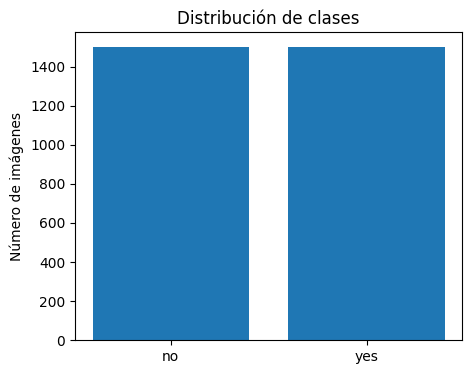

In [12]:

image_paths = {cls: [] for cls in classes}

for cls in classes:
    folder = os.path.join(root, cls)
    for name in os.listdir(folder):
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths[cls].append(os.path.join(folder, name))

for cls in classes:
    print(f"{cls}: {len(image_paths[cls])} imágenes")

plt.figure(figsize=(5,4))
plt.bar(classes, [len(image_paths[c]) for c in classes])
plt.title("Distribución de clases")
plt.ylabel("Número de imágenes")
plt.show()


In [13]:
heights = []
widths = []
mins = []
maxs = []
means = []
vars_ = []

for cls in classes:
    for fp in image_paths[cls]:
        img = Image.open(fp).convert("L")  # grayscale, no resizing
        arr = np.array(img).astype(np.float32)

        h, w = arr.shape
        heights.append(h)
        widths.append(w)

        mins.append(arr.min())
        maxs.append(arr.max())
        means.append(arr.mean())
        vars_.append(arr.var())

print("Height range:", min(heights), "→", max(heights))
print("Width range: ", min(widths), "→", max(widths))
print("Pixel min over dataset:", np.min(mins))
print("Pixel max over dataset:", np.max(maxs))
print("Global mean intensity:", np.mean(means))
print("Global variance:", np.mean(vars_))


Height range: 167 → 1427
Width range:  150 → 1920
Pixel min over dataset: 0.0
Pixel max over dataset: 255.0
Global mean intensity: 71.40063
Global variance: 4686.7285


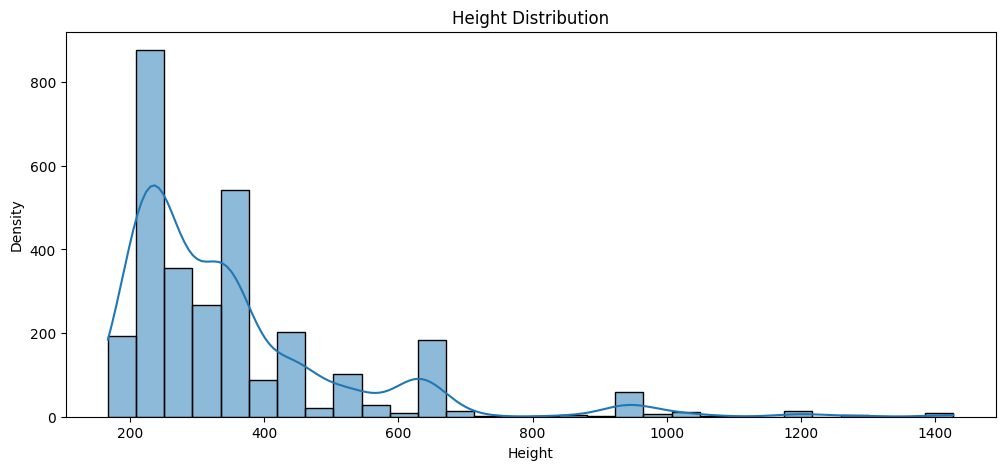

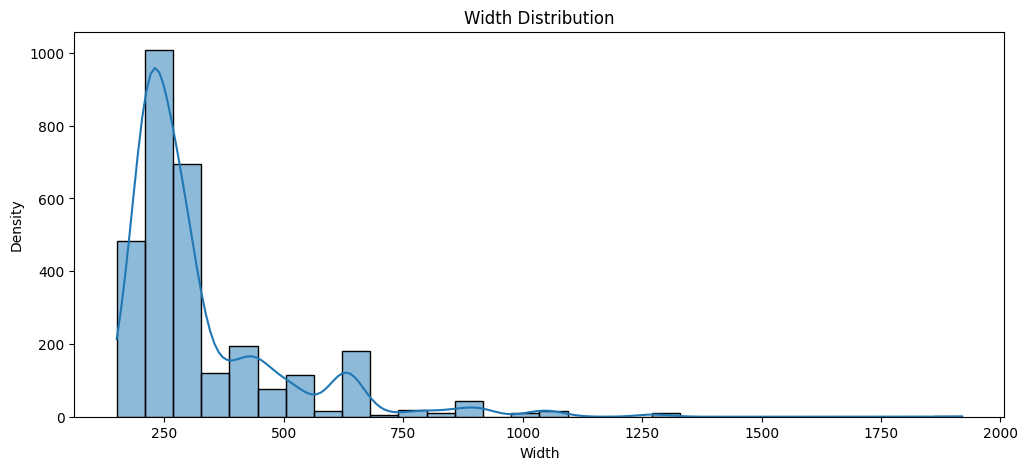

In [14]:
plt.figure(figsize=(12,5))
sns.histplot(heights, bins=30, kde=True)
plt.title("Height Distribution")
plt.xlabel("Height")
plt.ylabel("Density")

plt.figure(figsize=(12,5))
sns.histplot(widths, bins=30, kde=True)
plt.title("Width Distribution")
plt.xlabel("Width")
plt.ylabel("Density")
plt.show()


Tamaño dataset: 3861
Clases: ['Br35H-Mask-RCNN', 'no', 'pred', 'yes']


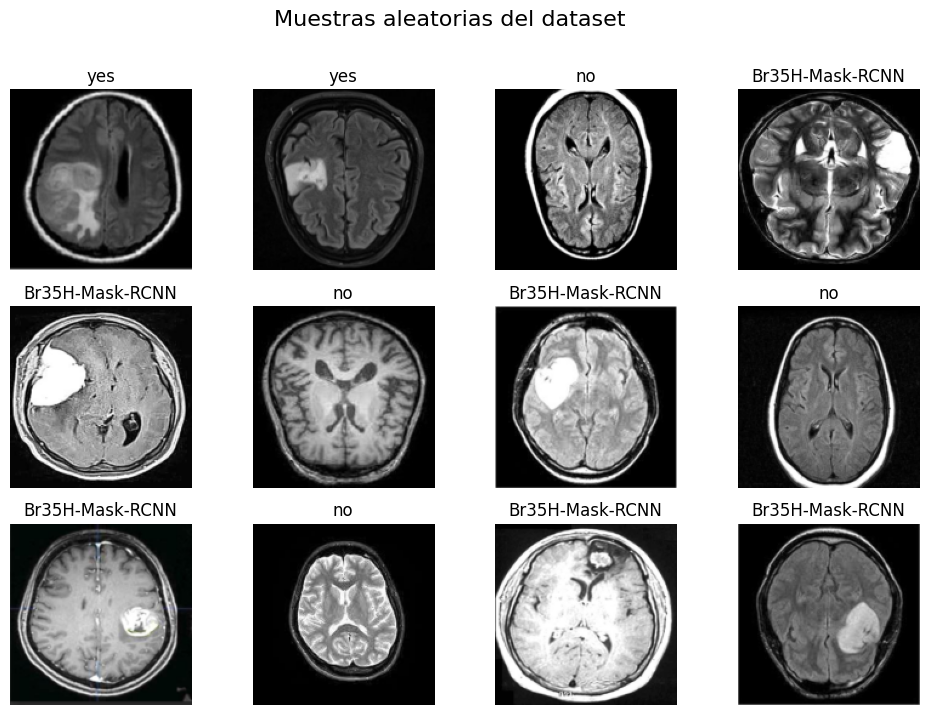

Shape OpenCV (BGR): (309, 232, 3)
Modo PIL: RGB


In [15]:
transform_simple = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=path, transform=transform_simple)
print("Tamaño dataset:", len(dataset))
print("Clases:", dataset.classes)


plt.figure(figsize=(12,8))
for i in range(12):
    img, label = dataset[random.randint(0, len(dataset)-1)]
    img_np = img.permute(1,2,0).numpy()
    plt.subplot(3,4,i+1)
    plt.imshow(img_np)
    plt.title(dataset.classes[label])
    plt.axis("off")
plt.suptitle("Muestras aleatorias del dataset", fontsize=16)
plt.show()


sample_path = dataset.samples[0][0]
img_cv = cv2.imread(sample_path)
img_pil = Image.open(sample_path)

print("Shape OpenCV (BGR):", img_cv.shape)
print("Modo PIL:", img_pil.mode)

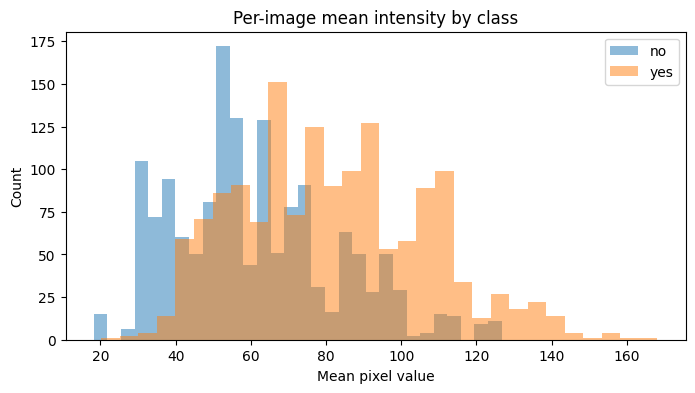

In [16]:
class_means = {cls: [] for cls in classes}

for cls in classes:
    for fp in image_paths[cls]:
        img = Image.open(fp).convert("L")
        arr = np.array(img).astype(np.float32)
        class_means[cls].append(arr.mean())

plt.figure(figsize=(8,4))
for cls in classes:
    plt.hist(class_means[cls], bins=30, alpha=0.5, label=cls)

plt.title("Per-image mean intensity by class")
plt.xlabel("Mean pixel value")
plt.ylabel("Count")
plt.legend()
plt.show()


Imágenes corruptas encontradas: 0
[]


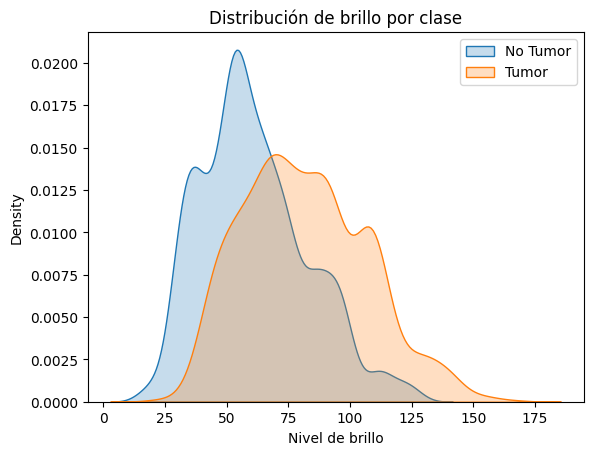

In [17]:

corrupt = []
for folder in ["yes", "no"]:
    folder_path = os.path.join(path, folder)
    for f in os.listdir(folder_path):
        try:
            Image.open(os.path.join(folder_path, f)).verify()
        except:
            corrupt.append(os.path.join(folder_path, f))

print("Imágenes corruptas encontradas:", len(corrupt))
print(corrupt[:5])

brightness_yes, brightness_no = [], []

for label in ["yes", "no"]:
    folder = os.path.join(path, label)
    for f in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            if label == "yes":
                brightness_yes.append(img.mean())
            else:
                brightness_no.append(img.mean())

sns.kdeplot(brightness_no, label="No Tumor", shade=True)
sns.kdeplot(brightness_yes, label="Tumor", shade=True)
plt.xlabel("Nivel de brillo")
plt.title("Distribución de brillo por clase")
plt.legend()
plt.show()


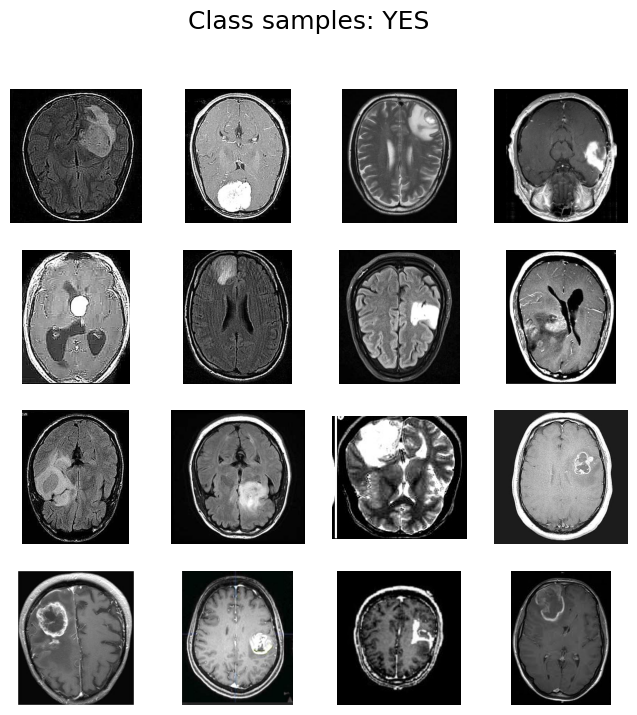

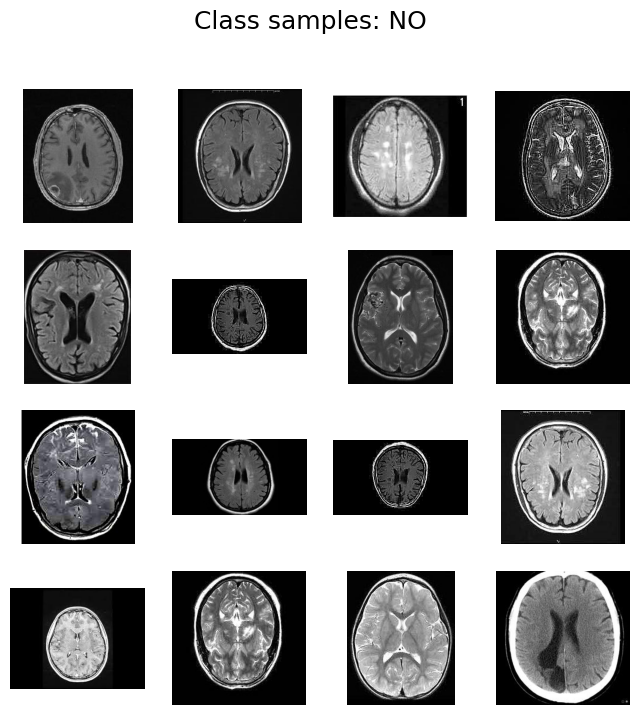

In [18]:
def plot_collage(label):
    folder = os.path.join(path, label)
    imgs = os.listdir(folder)[:16]

    plt.figure(figsize=(8,8))
    for i, img_name in enumerate(imgs):
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Class samples: {label.upper()}", fontsize=18)
    plt.show()

plot_collage("yes")
plot_collage("no")



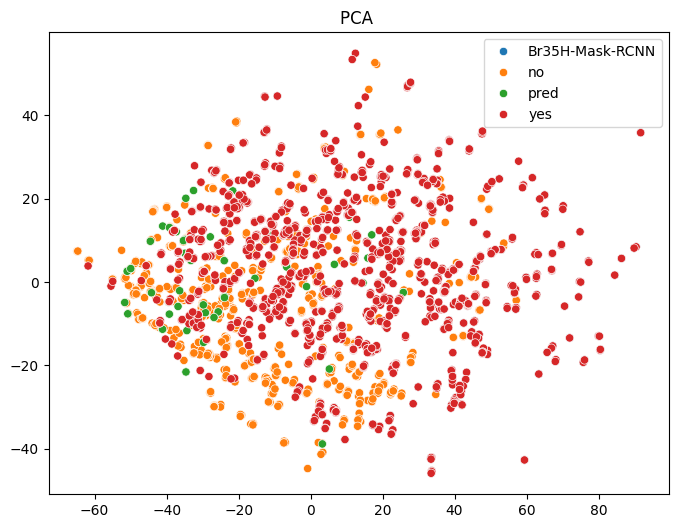

In [19]:
from sklearn.decomposition import PCA

# usage of PCA for dimensionality reduction
flat_images = []
labels = []

for img, label in dataset:
    flat_images.append(img.view(-1).numpy())
    labels.append(label)

pca = PCA(n_components=2)
components = pca.fit_transform(flat_images)
components = np.array(components)
plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1],
                hue=[dataset.classes[l] for l in labels])
plt.title("PCA ")
plt.show()

In [20]:
# usage of UMAP for dimensionality reduction
flat_images = []
labels = []

for img, label in dataset:
    flat_images.append(img.view(-1).numpy())
    labels.append(label)
flat_images = np.array(flat_images)
labels = np.array(labels)

print(flat_images)

[[0.02352941 0.02352941 0.02352941 ... 0.02352941 0.02352941 0.02352941]
 [0.08627451 0.07450981 0.03137255 ... 0.00392157 0.00392157 0.00392157]
 [0.07843138 0.07843138 0.07843138 ... 0.01568628 0.01568628 0.01568628]
 ...
 [0.         0.         0.00392157 ... 0.00392157 0.00392157 0.00392157]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01568628 0.01568628 0.01568628 ... 0.         0.         0.        ]]


Shape: (3861, 67500)


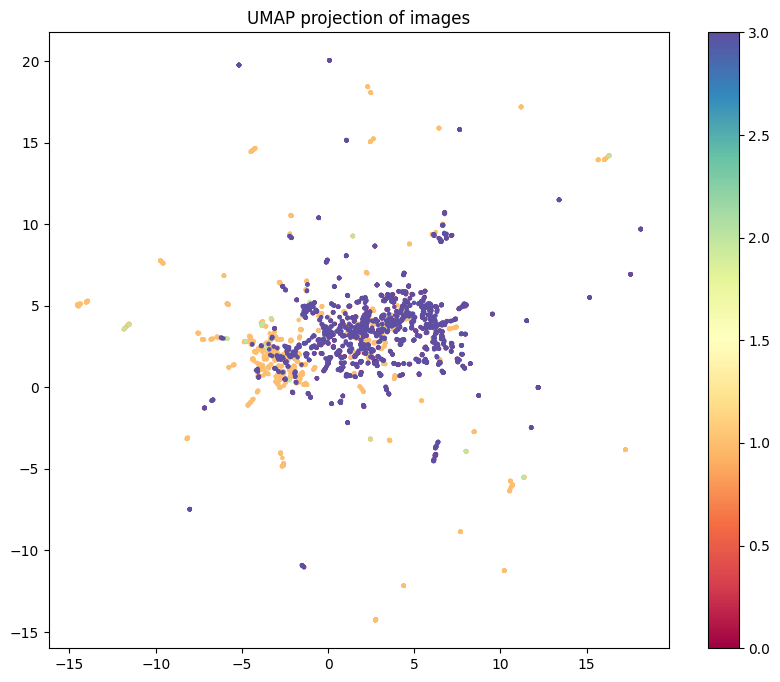

In [21]:
import umap
import matplotlib.pyplot as plt

#(assuming single images, not batches)
flat_images = []
labels = []

for img, label in dataset:
    # If img has batch dimension, remove it
    if img.dim() == 4:  # [batch, C, H, W]
        img = img.squeeze(0)
    flat_images.append(img.view(-1).numpy())
    labels.append(label if isinstance(label, int) else label.item())

flat_images = np.array(flat_images)
labels = np.array(labels)

print(f"Shape: {flat_images.shape}")  # Should be (n_samples, n_features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(flat_images)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of images')
plt.show()

##Dataset Summary

We explored the "Brain Tumor Detection" dataset from Kaggle. The dataset contains MRI axial brain scans separated into two domains: tumor and no-tumor, which makes it suitable for domain-translation tasks such as CycleGAN.

#Key Findings

Body part: Human brain (MRI axial slices).

Image type: RGB files, but visually grayscale (3 identical channels).

Resolution: Highly variable (height 160–1300 px, width 200–1000 px).

Class distribution: Slight imbalance between tumor and non-tumor classes.

MRI characteristics: Tumors present strong intensity variation, shape heterogeneity and texture differences.

Dataset quality: No corrupt images detected; images well-organized into class-labeled folders.

#Preprocessing

In [22]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [23]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = img.astype(np.float32)

            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.ToTensor()(img)

            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return img, label

        except:
            blank = torch.zeros(3, 224, 224)
            return blank, torch.tensor(self.labels[idx], dtype=torch.long)



In [24]:
def prepare_data_paths(data_path):
    image_paths = []
    labels = []
    class_names = ['no', 'yes']

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    image_paths.append(img_path)
                    labels.append(class_idx)

    return image_paths, labels, class_names

print("Cargando paths...")
image_paths, labels, class_names = prepare_data_paths(path)
print(f"Total imágenes: {len(image_paths)}")
print(f"Clases: {class_names[0]}: {labels.count(0)}, {class_names[1]}: {labels.count(1)}")

# Splits estratificados
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train_paths)}")
print(f"Val:   {len(X_val_paths)}")
print(f"Test:  {len(X_test_paths)}")

# Pesos de clase por imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


Cargando paths...
Total imágenes: 3000
Clases: no: 1500, yes: 1500
Train: 2100
Val:   450
Test:  450
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [25]:
train_dataset = BrainMRIDataset(X_train_paths, y_train, transform=train_transform)
val_dataset   = BrainMRIDataset(X_val_paths, y_val,   transform=val_test_transform)
test_dataset  = BrainMRIDataset(X_test_paths, y_test, transform=val_test_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)


In [26]:
class BasicBlock(nn.Module): # initalise basic residual block
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x): #forward pass implementing residual connection
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None): #initialise a bottleneck residual block
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x): #forward pass with bottleneck residual connection
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [27]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000): #initialise resnet architechture implemetnation
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1): #create a layer consisting of multiple residual block
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x): #forward pass through entire resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=2):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=2):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [28]:
def train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    device, num_epochs=20, patience=5
):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for imgs, labels in tqdm(train_loader, desc="Training"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, pred = outputs.max(1)
            train_total += labels.size(0)
            train_correct += pred.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_correct / train_total)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc="Validating"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(
            f"Train Loss: {train_losses[-1]:.4f} | "
            f"Val Loss: {val_losses[-1]:.4f} | "
            f"Train Acc: {train_accs[-1]*100:.2f}% | "
            f"Val Acc: {val_accs[-1]*100:.2f}%"
        )


        scheduler.step(val_losses[-1])
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            torch.save(model.state_dict(), "best_resnet18.pth")
            print("Modelo")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(" Early stopping activado!")
                break

    return train_losses, val_losses, train_accs, val_accs


In [29]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_probs, classes):
    n_classes = len(classes)

    # Convert labels to binary format for multi-class ROC
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Multi-class')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_metrics(y_true, y_pred, classes):
    # Accuracy
    accuracy = 100 * np.mean(y_true == y_pred)
    print(f'\nOverall Accuracy: {accuracy:.2f}%')

    # F1 Score (macro and weighted)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Macro): {f1_macro:.4f}')
    print(f'F1 Score (Weighted): {f1_weighted:.4f}')

    # Classification Report
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = resnet18(num_classes=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2
)


weights_tensor = torch.tensor([class_weight_dict[i] for i in range(2)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)


train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    device, num_epochs=30, patience=6
)

Device: cpu

===== Epoch 1/30 =====


Training:   8%|▊         | 5/66 [00:52<10:43, 10.54s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curves")
plt.legend()
plt.show()


In [ ]:
best_model = resnet18(num_classes=2).to(device)
best_model.load_state_dict(torch.load("best_resnet18.pth"))

y_pred, y_true, y_probs = evaluate_model(best_model, test_loader, device)

print_metrics(y_true, y_pred, class_names)
plot_confusion_matrix(y_true, y_pred, class_names)


# CycleGAN implementation
### All done using torch and not tensorflow like the one from the repository as most of the code is already done in PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

### Adapted preprocessing

In [ ]:
# Configuration
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Separate data by class - adapt based on your number of classes
# If binary (0=no tumor, 1=tumor):
domain_A_train = [path for path, label in zip(X_train_paths, y_train) if label == 0]
domain_B_train = [path for path, label in zip(X_train_paths, y_train) if label == 1]

domain_A_val = [path for path, label in zip(X_val_paths, y_val) if label == 0]
domain_B_val = [path for path, label in zip(X_val_paths, y_val) if label == 1]

domain_A_test = [path for path, label in zip(X_test_paths, y_test) if label == 0]
domain_B_test = [path for path, label in zip(X_test_paths, y_test) if label == 1]

print(f"Train - Domain A (no tumor): {len(domain_A_train)}, Domain B (tumor): {len(domain_B_train)}")
print(f"Val - Domain A: {len(domain_A_val)}, Domain B: {len(domain_B_val)}")
print(f"Test - Domain A: {len(domain_A_test)}, Domain B: {len(domain_B_test)}")

# Custom transforms with random jitter
class RandomJitter:
    def __call__(self, img):
        # Resize to 286x286
        resize = transforms.Resize((286, 286), interpolation=transforms.InterpolationMode.NEAREST)
        img = resize(img)

        # Random crop to 256x256
        crop = transforms.RandomCrop((IMG_HEIGHT, IMG_WIDTH))
        img = crop(img)

        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = transforms.functional.hflip(img)

        return img
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    RandomJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Test/Val transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Unpaired Dataset for CycleGAN
class UnpairedDataset(Dataset):
    def __init__(self, paths_A, paths_B, transform=None):
        self.paths_A = paths_A
        self.paths_B = paths_B
        self.transform = transform
        self.len_A = len(paths_A)
        self.len_B = len(paths_B)

    def __len__(self):
        return max(self.len_A, self.len_B)

    def __getitem__(self, idx):
        # Wrap around if one domain has fewer images
        idx_A = idx % self.len_A
        idx_B = idx % self.len_B

        img_A = Image.open(self.paths_A[idx_A])
        img_B = Image.open(self.paths_B[idx_B])

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}

# Create datasets
train_dataset = UnpairedDataset(domain_A_train, domain_B_train, transform=train_transform)
val_dataset = UnpairedDataset(domain_A_val, domain_B_val, transform=test_transform)
test_dataset = UnpairedDataset(domain_A_test, domain_B_test, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Visualization function
def show_sample(dataloader, title_A="Domain A", title_B="Domain B"):
    sample = next(iter(dataloader))
    sample_A = sample['A'][0]
    sample_B = sample['B'][0]

    # Denormalize from [-1, 1] to [0, 1]
    sample_A = sample_A * 0.5 + 0.5
    sample_B = sample_B * 0.5 + 0.5

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(sample_A.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title(title_A)
    axes[0].axis('off')

    axes[1].imshow(sample_B.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title(title_B)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Show samples
print("\nTrain samples:")
show_sample(train_loader, "No Tumor (Train)", "Tumor (Train)")

print("\nTest samples (no augmentation):")
show_sample(test_loader, "No Tumor (Test)", "Tumor (Test)")

# Show augmentation effect
print("\nAugmentation comparison:")
sample = next(iter(train_loader))
original = sample['A'][0] * 0.5 + 0.5

# Load and apply augmentation multiple times
img = Image.open(domain_A_train[0])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    if i == 0:
        # Original (just normalized, no jitter)
        img_tensor = test_transform(img)
    else:
        # With random jitter
        img_tensor = train_transform(img)

    img_show = img_tensor * 0.5 + 0.5
    ax.imshow(img_show.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Sample {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


### Adapted Model initialisation (generator and discriminators)

In [32]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, features, normalize=False)   # 128 -> 64
        self.enc2 = self.conv_block(features, features*2)                     # 64 -> 32
        self.enc3 = self.conv_block(features*2, features*4)                   # 32 -> 16
        self.enc4 = self.conv_block(features*4, features*8)                   # 16 -> 8
        self.enc5 = self.conv_block(features*8, features*8)                   # 8 → 4
        self.enc6 = self.conv_block(features*8, features*8, normalize=False)  # 4 → 2  (no normalización)

        # Bottleneck (2x2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )  # 2 → 1

        # Decoder
        self.dec1 = self.upconv_block(features*8, features*8)                 # 1 → 2
        self.dec2 = self.upconv_block(features*16, features*8)                # 2 → 4
        self.dec3 = self.upconv_block(features*16, features*8)                # 4 → 8
        self.dec4 = self.upconv_block(features*16, features*4)                # 8 → 16
        self.dec5 = self.upconv_block(features*8, features*2)                 # 16 → 32
        self.dec6 = self.upconv_block(features*4, features)                   # 32 → 64

        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels,
                               kernel_size=4, stride=2, padding=1),           # 64 → 128
            nn.Tanh()
        )

    def conv_block(self, in_c, out_c, normalize=True):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def upconv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        b = self.bottleneck(e6)

        d1 = self.dec1(b)
        d1 = torch.cat([d1, e6], dim=1)

        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e5], dim=1)

        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e4], dim=1)

        d4 = self.dec4(d3)
        d4 = torch.cat([d4, e3], dim=1)

        d5 = self.dec5(d4)
        d5 = torch.cat([d5, e2], dim=1)

        d6 = self.dec6(d5)
        d6 = torch.cat([d6, e1], dim=1)

        return self.final(d6)


In [33]:
class PatchGANDiscriminator(nn.Module):
    """
    PatchGAN Discriminator
    Classifies NxN image patches as real or fake instead of whole image.
    """

    def __init__(self, in_channels=3, features=64):
        super(PatchGANDiscriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: (in_channels) x 128 x 128
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: 1 x 14 x 14 (patch realism map)
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


### Adapted loss function

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
LAMBDA = 10  # Weight for cycle consistency loss
LAMBDA_IDENTITY = 0.5  # Weight for identity loss
LEARNING_RATE = 2e-4
BETA1 = 0.5
OUTPUT_CHANNELS = 3


# Loss Functions
def calc_cycle_loss(real_image, cycled_image):
    """
    Cycle consistency loss: ||F(G(x)) - x|| + ||G(F(y)) - y||
    Ensures that if we translate from domain A to B and back to A,
    we get the original image
    """
    loss = torch.mean(torch.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    """
    Identity loss: ||G(y) - y|| + ||F(x) - x||
    Encourages generators to preserve color composition when given
    images from the target domain
    """
    loss = torch.mean(torch.abs(real_image - same_image))
    return LAMBDA * LAMBDA_IDENTITY * loss

def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss using MSE (LSGAN)
    Real images should have output close to 1, fake images close to 0
    """
    real_loss = torch.mean((real_output - 1) ** 2)
    fake_loss = torch.mean(fake_output ** 2)
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss

def generator_loss(fake_output):
    """
    Generator loss using MSE (LSGAN)
    Generator wants discriminator to classify fake images as real (1)
    """
    return torch.mean((fake_output - 1) ** 2)

generator_g = UNetGenerator(OUTPUT_CHANNELS, OUTPUT_CHANNELS).to(device)
generator_f = UNetGenerator(OUTPUT_CHANNELS, OUTPUT_CHANNELS).to(device)

discriminator_x = PatchGANDiscriminator(OUTPUT_CHANNELS).to(device)
discriminator_y = PatchGANDiscriminator(OUTPUT_CHANNELS).to(device)

# Optimizers
generator_g_optimizer = optim.Adam(
    generator_g.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

generator_f_optimizer = optim.Adam(
    generator_f.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

discriminator_x_optimizer = optim.Adam(
    discriminator_x.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

discriminator_y_optimizer = optim.Adam(
    discriminator_y.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)


print("Loss functions and optimizers initialized!")
print(f"Cycle loss weight (LAMBDA): {LAMBDA}")
print(f"Identity loss weight: {LAMBDA * LAMBDA_IDENTITY}")
print(f"Learning rate: {LEARNING_RATE}")



# Test loss functions with sample data
sample = next(iter(train_loader))
sample_A = sample['A'].to(device)
sample_B = sample['B'].to(device)

with torch.no_grad():
    # Forward pass
    fake_B = generator_g(sample_A)
    fake_A = generator_f(sample_B)

    # Cycle
    cycled_A = generator_f(fake_B)
    cycled_B = generator_g(fake_A)

    # Identity
    same_A = generator_f(sample_A)
    same_B = generator_g(sample_B)

    # Calculate losses
    cycle_loss_A = calc_cycle_loss(sample_A, cycled_A)
    cycle_loss_B = calc_cycle_loss(sample_B, cycled_B)

    identity_loss_A = identity_loss(sample_A, same_A)
    identity_loss_B = identity_loss(sample_B, same_B)

    # Discriminator outputs
    disc_real_A = discriminator_x(sample_A)
    disc_fake_A = discriminator_x(fake_A)
    disc_real_B = discriminator_y(sample_B)
    disc_fake_B = discriminator_y(fake_B)

    # Discriminator losses
    disc_loss_A = discriminator_loss(disc_real_A, disc_fake_A)
    disc_loss_B = discriminator_loss(disc_real_B, disc_fake_B)

    # Generator losses
    gen_loss_g = generator_loss(disc_fake_B)
    gen_loss_f = generator_loss(disc_fake_A)

print("\nSample loss values:")
print(f"Cycle loss A: {cycle_loss_A.item():.4f}")
print(f"Cycle loss B: {cycle_loss_B.item():.4f}")
print(f"Identity loss A: {identity_loss_A.item():.4f}")
print(f"Identity loss B: {identity_loss_B.item():.4f}")
print(f"Discriminator A loss: {disc_loss_A.item():.4f}")
print(f"Discriminator B loss: {disc_loss_B.item():.4f}")
print(f"Generator G loss: {gen_loss_g.item():.4f}")
print(f"Generator F loss: {gen_loss_f.item():.4f}")

# Visualize cycle consistency
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

def show_img(ax, img, title):
    img = (img * 0.5 + 0.5).clamp(0, 1)
    ax.imshow(img.cpu().permute(1, 2, 0).numpy())
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# First row: A -> B -> A
show_img(axes[0, 0], sample_A[0], 'Real A (No Tumor)')
show_img(axes[0, 1], fake_B[0], 'Fake B (Generated Tumor)')
show_img(axes[0, 2], cycled_A[0], 'Cycled A (Reconstructed)')
show_img(axes[0, 3], sample_A[0] - cycled_A[0], 'Cycle Error A')

# Second row: B -> A -> B
show_img(axes[1, 0], sample_B[0], 'Real B (Tumor)')
show_img(axes[1, 1], fake_A[0], 'Fake A (Generated No Tumor)')
show_img(axes[1, 2], cycled_B[0], 'Cycled B (Reconstructed)')
show_img(axes[1, 3], sample_B[0] - cycled_B[0], 'Cycle Error B')

plt.tight_layout()
plt.show()

Loss functions and optimizers initialized!
Cycle loss weight (LAMBDA): 10
Identity loss weight: 5.0
Learning rate: 0.0002


TypeError: list indices must be integers or slices, not str

### Checkpoints

In [ ]:
import os
from pathlib import Path

# Checkpoint configuration
checkpoint_dir = "./checkpoints/train"
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

def save_checkpoint(epoch, generator_g, generator_f, discriminator_x, discriminator_y,
                   gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt,
                   losses=None, filename=None):
    """Save model checkpoint"""
    if filename is None:
        filename = f"checkpoint_epoch_{epoch}.pt"

    filepath = os.path.join(checkpoint_dir, filename)

    checkpoint = {
        'epoch': epoch,
        'generator_g_state_dict': generator_g.state_dict(),
        'generator_f_state_dict': generator_f.state_dict(),
        'discriminator_x_state_dict': discriminator_x.state_dict(),
        'discriminator_y_state_dict': discriminator_y.state_dict(),
        'generator_g_optimizer': gen_g_opt.state_dict(),
        'generator_f_optimizer': gen_f_opt.state_dict(),
        'discriminator_x_optimizer': disc_x_opt.state_dict(),
        'discriminator_y_optimizer': disc_y_opt.state_dict(),
    }

    if losses is not None:
        checkpoint['losses'] = losses

    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

    # Keep only last 5 checkpoints
    checkpoints = sorted(Path(checkpoint_dir).glob("checkpoint_epoch_*.pt"))
    if len(checkpoints) > 5:
        for old_ckpt in checkpoints[:-5]:
            old_ckpt.unlink()
            print(f"Removed old checkpoint: {old_ckpt}")

    return filepath

def load_checkpoint(generator_g, generator_f, discriminator_x, discriminator_y,
                   gen_g_opt, gen_f_opt, disc_x_opt, disc_y_opt,
                   checkpoint_path=None):
    """Load model checkpoint"""

    if checkpoint_path is None:
        # Find latest checkpoint
        checkpoints = sorted(Path(checkpoint_dir).glob("checkpoint_epoch_*.pt"))
        if not checkpoints:
            print("No checkpoint found. Starting from scratch.")
            return 0, None
        checkpoint_path = checkpoints[-1]

    print(f"Loading checkpoint: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    generator_g.load_state_dict(checkpoint['generator_g_state_dict'])
    generator_f.load_state_dict(checkpoint['generator_f_state_dict'])
    discriminator_x.load_state_dict(checkpoint['discriminator_x_state_dict'])
    discriminator_y.load_state_dict(checkpoint['discriminator_y_state_dict'])

    gen_g_opt.load_state_dict(checkpoint['generator_g_optimizer'])
    gen_f_opt.load_state_dict(checkpoint['generator_f_optimizer'])
    disc_x_opt.load_state_dict(checkpoint['discriminator_x_optimizer'])
    disc_y_opt.load_state_dict(checkpoint['discriminator_y_optimizer'])

    epoch = checkpoint['epoch']
    losses = checkpoint.get('losses', None)

    print(f"Checkpoint restored! Resuming from epoch {epoch}")

    return epoch, losses

def get_latest_checkpoint():
    """Get path to latest checkpoint"""
    checkpoints = sorted(Path(checkpoint_dir).glob("checkpoint_epoch_*.pt"))
    return checkpoints[-1] if checkpoints else None

# Try to restore latest checkpoint
latest_checkpoint = get_latest_checkpoint()

if latest_checkpoint:
    start_epoch, saved_losses = load_checkpoint(
        generator_g, generator_f,
        discriminator_x, discriminator_y,
        generator_g_optimizer, generator_f_optimizer,
        discriminator_x_optimizer, discriminator_y_optimizer
    )
    print(f"Latest checkpoint restored from epoch {start_epoch}!")
else:
    start_epoch = 0
    saved_losses = None
    print("No checkpoint found. Starting training from scratch.")

# Also save best model separately
def save_best_model(generator_g, generator_f, epoch, gen_g_loss, cycle_loss):
    filepath = os.path.join(checkpoint_dir, "best_model.pt")

    checkpoint = {
        'epoch': epoch,
        'generator_g_state_dict': generator_g.state_dict(),
        'generator_f_state_dict': generator_f.state_dict(),
        'gen_g_loss': gen_g_loss,
        'cycle_loss': cycle_loss
    }

    torch.save(checkpoint, filepath)
    print(f"✓ Best model saved at epoch {epoch} | G Loss: {gen_g_loss:.4f}, Cycle Loss: {cycle_loss:.4f}")


def load_best_model(generator_g, generator_f):
    """Load best model for inference"""
    filepath = os.path.join(checkpoint_dir, "best_model.pt")

    if not os.path.exists(filepath):
        print("No best model found.")
        return None

    checkpoint = torch.load(filepath, map_location=device)
    generator_g.load_state_dict(checkpoint['generator_g_state_dict'])
    generator_g.eval()  # Set to evaluation mode

    print(f"Best Generator G model loaded from epoch {checkpoint['epoch']}")
    print(f"Generator G loss: {checkpoint['gen_g_loss']:.4f}")
    return checkpoint

print("\nCheckpoint system ready!")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Starting from epoch: {start_epoch}")

### Training

In [ ]:
EPOCHS = 100

In [ ]:
def train_step(
    real_A, real_B,
    generator_g, generator_f,
    discriminator_x, discriminator_y,
    generator_g_optimizer, generator_f_optimizer,
    discriminator_x_optimizer, discriminator_y_optimizer
):
    # --- GENERATOR TRAINING ---
    generator_g_optimizer.zero_grad()
    generator_f_optimizer.zero_grad()

    # A → B
    fake_B = generator_g(real_A)
    disc_fake_B = discriminator_y(fake_B)

    # B → A
    fake_A = generator_f(real_B)
    disc_fake_A = discriminator_x(fake_A)

    # Adversarial losses
    gen_g_adv = generator_loss(disc_fake_B)
    gen_f_adv = generator_loss(disc_fake_A)

    # Cycle losses
    cycled_A = generator_f(fake_B)
    cycled_B = generator_g(fake_A)
    cycle_A_loss = calc_cycle_loss(real_A, cycled_A)
    cycle_B_loss = calc_cycle_loss(real_B, cycled_B)

    # Identity losses
    same_A = generator_f(real_A)
    same_B = generator_g(real_B)
    id_A_loss = identity_loss(real_A, same_A)
    id_B_loss = identity_loss(real_B, same_B)

    # Total generator loss
    total_gen_loss = (
        gen_g_adv + gen_f_adv +
        cycle_A_loss + cycle_B_loss +
        id_A_loss + id_B_loss
    )

    total_gen_loss.backward()
    generator_g_optimizer.step()
    generator_f_optimizer.step()

    # --- DISCRIMINATOR TRAINING ---
    discriminator_x_optimizer.zero_grad()
    discriminator_y_optimizer.zero_grad()

    # Discriminator A
    disc_real_A = discriminator_x(real_A)
    disc_fake_A = discriminator_x(fake_A.detach())
    disc_x_loss = discriminator_loss(disc_real_A, disc_fake_A)

    # Discriminator B
    disc_real_B = discriminator_y(real_B)
    disc_fake_B = discriminator_y(fake_B.detach())
    disc_y_loss = discriminator_loss(disc_real_B, disc_fake_B)

    total_disc_loss = disc_x_loss + disc_y_loss
    total_disc_loss.backward()

    discriminator_x_optimizer.step()
    discriminator_y_optimizer.step()

    return {
        'gen_g_loss': gen_g_adv.item(),
        'gen_f_loss': gen_f_adv.item(),
        'disc_x_loss': disc_x_loss.item(),
        'disc_y_loss': disc_y_loss.item(),
        'cycle_loss': (cycle_A_loss + cycle_B_loss).item(),
        'identity_loss': (id_A_loss + id_B_loss).item()
    }


def validate(val_loader, generator_g, generator_f, discriminator_x, discriminator_y):
    generator_g.eval()
    generator_f.eval()
    discriminator_x.eval()
    discriminator_y.eval()

    val_losses = {
        'gen_g_loss': 0, 'gen_f_loss': 0,
        'disc_x_loss': 0, 'disc_y_loss': 0,
        'cycle_loss': 0, 'identity_loss': 0
    }

    with torch.no_grad():
        for batch in val_loader:
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            # A → B
            fake_B = generator_g(real_A)
            disc_fake_B = discriminator_y(fake_B)

            # B → A
            fake_A = generator_f(real_B)
            disc_fake_A = discriminator_x(fake_A)

            # Losses
            gen_g_adv = generator_loss(disc_fake_B)
            gen_f_adv = generator_loss(disc_fake_A)

            # Cycle
            cycled_A = generator_f(fake_B)
            cycled_B = generator_g(fake_A)
            cycle_loss = calc_cycle_loss(real_A, cycled_A) + calc_cycle_loss(real_B, cycled_B)

            # Identity
            id_loss = identity_loss(real_A, generator_f(real_A)) + identity_loss(real_B, generator_g(real_B))

            # Discriminators
            disc_x_loss = discriminator_loss(discriminator_x(real_A), discriminator_x(fake_A))
            disc_y_loss = discriminator_loss(discriminator_y(real_B), discriminator_y(fake_B))

            val_losses['gen_g_loss'] += gen_g_adv.item()
            val_losses['gen_f_loss'] += gen_f_adv.item()
            val_losses['disc_x_loss'] += disc_x_loss.item()
            val_losses['disc_y_loss'] += disc_y_loss.item()
            val_losses['cycle_loss'] += cycle_loss.item()
            val_losses['identity_loss'] += id_loss.item()

    # promediar
    for key in val_losses:
        val_losses[key] /= len(val_loader)

    return val_losses


In [ ]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Training configuration
EPOCHS = 100
import torch
if 'device' not in locals() and 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

# Training loop
print(f"Starting training for {EPOCHS} epochs...")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Loss tracking
train_loss_history = {
    'gen_g': [], 'gen_f': [],
    'disc_x': [], 'disc_y': [],
    'cycle': [], 'identity': []
}

val_loss_history = {
    'gen_g': [], 'gen_f': [],
    'disc_x': [], 'disc_y': [],
    'cycle': [], 'identity': []
}

best_val_loss = float('inf')

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()

    # ==========================
    # TRAINING PHASE
    # ==========================
    epoch_losses = {
        'gen_g_loss': 0, 'gen_f_loss': 0,
        'disc_x_loss': 0, 'disc_y_loss': 0,
        'cycle_loss': 0, 'identity_loss': 0
    }

    generator_g.train()
    generator_f.train()
    discriminator_x.train()
    discriminator_y.train()

    for i, batch in enumerate(train_loader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        losses = train_step(
            real_A, real_B,
            generator_g, generator_f,
            discriminator_x, discriminator_y,
            generator_g_optimizer, generator_f_optimizer,
            discriminator_x_optimizer, discriminator_y_optimizer
        )

        for key in epoch_losses:
            epoch_losses[key] += losses[key]

        if i % 10 == 0:
            print('.', end='', flush=True)

    # Average training losses
    for key in epoch_losses:
        epoch_losses[key] /= len(train_loader)
        train_loss_history[key.replace('_loss', '')].append(epoch_losses[key])


    # VALIDATION PHASE
    val_losses = validate(val_loader, generator_g, generator_f, discriminator_x, discriminator_y)

    for key in val_losses:
        val_loss_history[key.replace('_loss', '')].append(val_losses[key])

    # Clear output and show progress
    clear_output(wait=True)

    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*70}")
    print(f"{'Metric':<25} {'Train':<20} {'Validation':<20}")
    print(f"{'-'*70}")
    print(f"{'Generator G Loss':<25} {epoch_losses['gen_g_loss']:<20.4f} {val_losses['gen_g_loss']:<20.4f}")
    print(f"{'Generator F Loss':<25} {epoch_losses['gen_f_loss']:<20.4f} {val_losses['gen_f_loss']:<20.4f}")
    print(f"{'Discriminator X Loss':<25} {epoch_losses['disc_x_loss']:<20.4f} {val_losses['disc_x_loss']:<20.4f}")
    print(f"{'Discriminator Y Loss':<25} {epoch_losses['disc_y_loss']:<20.4f} {val_losses['disc_y_loss']:<20.4f}")
    print(f"{'Cycle Loss':<25} {epoch_losses['cycle_loss']:<20.4f} {val_losses['cycle_loss']:<20.4f}")
    print(f"{'Identity Loss':<25} {epoch_losses['identity_loss']:<20.4f} {val_losses['identity_loss']:<20.4f}")
    print(f"{'-'*70}")
    print(f"Time: {time.time() - start_time:.2f} sec")
    print(f"{'='*70}\n")

    # REMOVED: Image generation during training
    # REMOVED: generate_images() calls

    # Save checkpoint every 5 epochs (KEEP THIS - essential)
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            epoch=epoch + 1,
            generator_g=generator_g,
            generator_f=generator_f,
            discriminator_x=discriminator_x,
            discriminator_y=discriminator_y,
            gen_g_opt=generator_g_optimizer,
            gen_f_opt=generator_f_optimizer,
            disc_x_opt=discriminator_x_optimizer,
            disc_y_opt=discriminator_y_optimizer,
            losses={'train': epoch_losses, 'val': val_losses}
        )

# Save best model based on Generator G loss + Cycle loss
composite_loss = val_losses['gen_g_loss'] + val_losses['cycle_loss']

if composite_loss < best_val_loss:
 best_val_loss = composite_loss
 save_best_model(
    generator_g,
    generator_f,
    epoch + 1,
    val_losses['gen_g_loss'],
    val_losses['cycle_loss']
)

 print(f"✓ New best model saved! Composite loss: {best_val_loss:.4f}")


print("\n" + "="*70)
print("Training completed!")
print("="*70)

# REMOVED: Loss curve plotting during training
# Will be done in post-training cell

### Generate using test dataset -- run after training is done




In [ ]:
# POST-TRAINING VISUALIZATION & ANALYSIS
print("="*70)
print("POST-TRAINING ANALYSIS")
print("="*70)

# 1. Load best model
load_best_model(generator_g, generator_f)

# 2. Plot loss curves (MOVED FROM TRAINING)
print("\n1. Plotting training history...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Generator G loss
axes[0, 0].plot(train_loss_history['gen_g'], label='Train Gen G', linewidth=2, color='blue')
axes[0, 0].plot(val_loss_history['gen_g'], label='Val Gen G', linewidth=2, linestyle='--', color='blue')
axes[0, 0].set_title('Generator G Loss (No Tumor -> Tumor)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Generator F loss
axes[0, 1].plot(train_loss_history['gen_f'], label='Train Gen F', linewidth=2, color='gray', alpha=0.6)
axes[0, 1].plot(val_loss_history['gen_f'], label='Val Gen F', linewidth=2, linestyle='--', color='gray', alpha=0.6)
axes[0, 1].set_title('Generator F Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cycle loss
axes[0, 2].plot(train_loss_history['cycle'], label='Train Cycle', linewidth=2, color='green')
axes[0, 2].plot(val_loss_history['cycle'], label='Val Cycle', linewidth=2, linestyle='--', color='green')
axes[0, 2].set_title('Cycle Consistency Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Discriminator losses
axes[1, 0].plot(train_loss_history['disc_x'], label='Train Disc X', linewidth=2)
axes[1, 0].plot(val_loss_history['disc_x'], label='Val Disc X', linewidth=2, linestyle='--')
axes[1, 0].set_title('Discriminator X Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(train_loss_history['disc_y'], label='Train Disc Y', linewidth=2)
axes[1, 1].plot(val_loss_history['disc_y'], label='Val Disc Y', linewidth=2, linestyle='--')
axes[1, 1].set_title('Discriminator Y Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(train_loss_history['identity'], label='Train Identity', linewidth=2, color='orange')
axes[1, 2].plot(val_loss_history['identity'], label='Val Identity', linewidth=2, linestyle='--', color='orange')
axes[1, 2].set_title('Identity Loss')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('CycleGAN Training History', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'training_validation_losses.png'), dpi=150)
plt.show()

print(f"Loss curves saved to: {checkpoint_dir}/training_validation_losses.png")

# 3. Show sample generations (MOVED FROM TRAINING)
print("\n2. Generating sample translations...")

# Get fresh samples
train_sample = next(iter(train_loader))
val_sample = next(iter(val_loader))
sample_A_vis = train_sample['A'].to(device)
val_A_vis = val_sample['A'].to(device)

print("Training samples - No Tumor -> Tumor:")


print("Validation samples - No Tumor -> Tumor:")


# 4. Print final metrics
print("\n3. Final Training Metrics:")
print(f"Best Generator G validation loss: {best_val_loss:.4f}")
print(f"Total epochs trained: {len(train_loss_history['gen_g'])}")
print(f"Final Generator G train loss: {train_loss_history['gen_g'][-1]:.4f}")
print(f"Final Generator G val loss: {val_loss_history['gen_g'][-1]:.4f}")

print("\n" + "="*70)
print("POST-TRAINING ANALYSIS COMPLETE")
print("="*70)

In [ ]:
print("="*70)
print("Testing on Test Set")
print("="*70)

# Load best model for testing
load_best_model(generator_g, generator_f)

# Set models to evaluation mode
generator_g.eval()
generator_f.eval()

# Test on a few samples from test set
print("\nGenerating predictions on test samples...\n")

# Get 5 samples from test set
test_samples_A = []
test_samples_B = []

for i, batch in enumerate(test_loader):
    if i >= 5:
        break
    test_samples_A.append(batch['A'])
    test_samples_B.append(batch['B'])

# Test Generator G: No Tumor -> Tumor
print("Generator G: No Tumor -> Tumor Predictions")
print("-"*70)

for i, test_input in enumerate(test_samples_A):
    test_input = test_input.to(device)

    with torch.no_grad():
        prediction = generator_g(test_input)

    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    titles = ['Input (No Tumor)', 'Generated (Tumor)']

    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.title(titles[j], fontsize=14)
        img = (display_list[j] * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(img.cpu().permute(1, 2, 0).numpy())
        plt.axis('off')

    plt.suptitle(f'Test Sample {i+1}/5 - Generator G', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print("\n")

# Test Generator F: Tumor -> No Tumor
print("Generator F: Tumor -> No Tumor Predictions")
print("-"*70)

for i, test_input in enumerate(test_samples_B):
    test_input = test_input.to(device)

    with torch.no_grad():
        prediction = generator_f(test_input)

    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    titles = ['Input (Tumor)', 'Generated (No Tumor)']

    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.title(titles[j], fontsize=14)
        img = (display_list[j] * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(img.cpu().permute(1, 2, 0).numpy())
        plt.axis('off')

    plt.suptitle(f'Test Sample {i+1}/5 - Generator F', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Evaluate cycle consistency on test set
print("\n" + "="*70)
print("Cycle Consistency Evaluation on Test Set")
print("="*70)

test_metrics = {
    'cycle_loss_A': 0,
    'cycle_loss_B': 0,
    'identity_loss_A': 0,
    'identity_loss_B': 0
}

with torch.no_grad():
    for batch in test_loader:
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # Forward cycle: A -> B -> A
        fake_B = generator_g(real_A)
        cycled_A = generator_f(fake_B)

        # Backward cycle: B -> A -> B
        fake_A = generator_f(real_B)
        cycled_B = generator_g(fake_A)

        # Identity
        same_A = generator_f(real_A)
        same_B = generator_g(real_B)

        # Calculate losses
        test_metrics['cycle_loss_A'] += calc_cycle_loss(real_A, cycled_A).item()
        test_metrics['cycle_loss_B'] += calc_cycle_loss(real_B, cycled_B).item()
        test_metrics['identity_loss_A'] += identity_loss(real_A, same_A).item()
        test_metrics['identity_loss_B'] += identity_loss(real_B, same_B).item()

# Average losses
for key in test_metrics:
    test_metrics[key] /= len(test_loader)

print(f"\nTest Set Metrics:")
print(f"  Cycle Loss A (No Tumor): {test_metrics['cycle_loss_A']:.4f}")
print(f"  Cycle Loss B (Tumor): {test_metrics['cycle_loss_B']:.4f}")
print(f"  Total Cycle Loss: {test_metrics['cycle_loss_A'] + test_metrics['cycle_loss_B']:.4f}")
print(f"  Identity Loss A: {test_metrics['identity_loss_A']:.4f}")
print(f"  Identity Loss B: {test_metrics['identity_loss_B']:.4f}")
print(f"  Total Identity Loss: {test_metrics['identity_loss_A'] + test_metrics['identity_loss_B']:.4f}")

# Show cycle consistency visually for one sample
print("\n" + "="*70)
print("Visual Cycle Consistency Check")
print("="*70)

test_sample = next(iter(test_loader))
test_A = test_sample['A'].to(device)
test_B = test_sample['B'].to(device)

with torch.no_grad():
    # A -> B -> A
    fake_B_from_A = generator_g(test_A)
    cycled_A_from_B = generator_f(fake_B_from_A)

    # B -> A -> B
    fake_A_from_B = generator_f(test_B)
    cycled_B_from_A = generator_g(fake_A_from_B)

# Visualize full cycle
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

def show_img(ax, img, title):
    img = (img * 0.5 + 0.5).clamp(0, 1)
    ax.imshow(img.cpu().permute(1, 2, 0).numpy())
    ax.set_title(title, fontsize=11)
    ax.axis('off')

# First row: A -> B -> A
show_img(axes[0, 0], test_A[0], 'Real A\n(No Tumor)')
show_img(axes[0, 1], fake_B_from_A[0], 'Fake B\n(Generated Tumor)')
show_img(axes[0, 2], cycled_A_from_B[0], 'Cycled A\n(Reconstructed)')
diff_A = torch.abs(test_A[0] - cycled_A_from_B[0])
show_img(axes[0, 3], diff_A, 'Reconstruction\nError')

# Second row: B -> A -> B
show_img(axes[1, 0], test_B[0], 'Real B\n(Tumor)')
show_img(axes[1, 1], fake_A_from_B[0], 'Fake A\n(Generated No Tumor)')
show_img(axes[1, 2], cycled_B_from_A[0], 'Cycled B\n(Reconstructed)')
diff_B = torch.abs(test_B[0] - cycled_B_from_A[0])
show_img(axes[1, 3], diff_B, 'Reconstruction\nError')

plt.suptitle('Cycle Consistency on Test Set', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'test_cycle_consistency.png'), dpi=150)
plt.show()

print("\n" + "="*70)
print("Testing Complete!")
print("="*70)
print(f"Results saved to: {checkpoint_dir}")

In [ ]:
def visualize_tumor_difference_maps_random(generator_g, generator_f, test_loader, device, n_samples=3):
    """
    Visualize difference maps with RANDOM samples each time

    Shows different test images on each run to assess generalization
    """

    print("="*70)
    print("TUMOR LOCATION DIFFERENCE MAPS (RANDOM SAMPLES)")
    print("="*70)
    print("Showing DIFFERENT random test samples on each run")
    print("Red/Positive values = Tumor presence")
    print("Blue/Negative values = Tumor absence")
    print("="*70 + "\n")

    generator_g.eval()
    generator_f.eval()

    # Get RANDOM samples from test set
    # Convert test_loader to list to sample randomly
    test_data_list = list(test_loader)

    # Randomly select batches
    random_batch_indices = np.random.choice(len(test_data_list),
                                           min(n_samples, len(test_data_list)),
                                           replace=False)

    samples = []
    for batch_idx in random_batch_indices:
        batch = test_data_list[batch_idx]
        # Randomly select one image from each batch
        random_img_idx = np.random.randint(0, batch['A'].size(0))
        samples.append((
            batch['A'][random_img_idx:random_img_idx+1].to(device),  # Single no-tumor
            batch['B'][random_img_idx:random_img_idx+1].to(device)   # Single tumor
        ))

    # Or alternative: directly sample from dataset if test_loader is small
    if len(samples) == 0:
        print("Warning: Could not get samples from loader, trying dataset...")
        # Get random indices from dataset
        dataset = test_loader.dataset
        random_indices = np.random.choice(len(dataset), n_samples, replace=False)
        for idx in random_indices:
            batch = dataset[idx]
            samples.append((
                batch['A'].unsqueeze(0).to(device),  # Add batch dimension
                batch['B'].unsqueeze(0).to(device)
            ))

    print(f"Showing {len(samples)} random test samples\n")

    fig, axes = plt.subplots(len(samples), 6, figsize=(24, 5*len(samples)))

    for idx, (real_A, real_B) in enumerate(samples):
        with torch.no_grad():
            # Generate translations
            fake_B = generator_g(real_A)  # No-tumor → Tumor
            fake_A = generator_f(real_B)  # Tumor → No-tumor

            # Calculate difference maps
            diff_tumor_removed = real_B - fake_A  # Positive = tumor region removed
            diff_tumor_added = fake_B - real_A    # Positive = tumor region added

            # Also show absolute differences for clarity
            diff_tumor_removed_abs = torch.abs(diff_tumor_removed)
            diff_tumor_added_abs = torch.abs(diff_tumor_added)

        # Denormalize images for display
        real_A_img = real_A[0] * 0.5 + 0.5
        real_B_img = real_B[0] * 0.5 + 0.5
        fake_A_img = fake_A[0] * 0.5 + 0.5
        fake_B_img = fake_B[0] * 0.5 + 0.5

        # Prepare difference maps for visualization
        diff_removed = diff_tumor_removed[0].cpu().numpy()
        diff_added = diff_tumor_added[0].cpu().numpy()
        diff_removed_abs = diff_tumor_removed_abs[0].cpu().numpy()
        diff_added_abs = diff_tumor_added_abs[0].cpu().numpy()

        # Calculate statistics for colormap scaling
        max_diff = max(np.abs(diff_removed).max(), np.abs(diff_added).max())

        # Plot 6 columns
        # Column 1: Original Tumor
        axes[idx, 0].imshow(real_B_img.cpu().permute(1, 2, 0).numpy())
        axes[idx, 0].set_title(f'Original Tumor\nSample {idx+1}', fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')

        # Column 2: Generated No-Tumor
        axes[idx, 1].imshow(fake_A_img.cpu().permute(1, 2, 0).numpy())
        axes[idx, 1].set_title(f'Generated No-Tumor', fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')

        # Column 3: Difference Map (Tumor → No-Tumor)
        im3 = axes[idx, 2].imshow(diff_removed.sum(axis=0),
                                 cmap='RdBu_r',
                                 vmin=-max_diff*2 if max_diff > 0 else -1,
                                 vmax=max_diff*2 if max_diff > 0 else 1)
        axes[idx, 2].set_title(f'Difference: Tumor Removed\nRed = Where tumor was',
                              fontsize=11, fontweight='bold')
        axes[idx, 2].axis('off')
        plt.colorbar(im3, ax=axes[idx, 2], fraction=0.046, pad=0.04)

        # Column 4: Original No-Tumor
        axes[idx, 3].imshow(real_A_img.cpu().permute(1, 2, 0).numpy())
        axes[idx, 3].set_title(f'Original No-Tumor\nSample {idx+1}', fontsize=11, fontweight='bold')
        axes[idx, 3].axis('off')

        # Column 5: Generated Tumor
        axes[idx, 4].imshow(fake_B_img.cpu().permute(1, 2, 0).numpy())
        axes[idx, 4].set_title(f'Generated Tumor', fontsize=11, fontweight='bold')
        axes[idx, 4].axis('off')

        # Column 6: Difference Map (No-Tumor → Tumor)
        im6 = axes[idx, 5].imshow(diff_added.sum(axis=0),
                                 cmap='RdBu_r',
                                 vmin=-max_diff*2 if max_diff > 0 else -1,
                                 vmax=max_diff*2 if max_diff > 0 else 1)
        axes[idx, 5].set_title(f'Difference: Tumor Added\nRed = Where tumor was added',
                              fontsize=11, fontweight='bold')
        axes[idx, 5].axis('off')
        plt.colorbar(im6, ax=axes[idx, 5], fraction=0.046, pad=0.04)

    plt.suptitle(f'Random Test Samples: Difference Maps Should Highlight Tumor Regions\n(Run again to see different samples)',
                 fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print sample information
    print("\n" + "="*70)
    print("SAMPLE INFORMATION")
    print("="*70)
    print(f"• Showing {len(samples)} random test samples")
    print(f"• Each sample shows tumor → no-tumor and no-tumor → tumor translations")
    print(f"• Difference maps show WHERE tumors are added/removed")
    print(f"• Run this cell again to see DIFFERENT random samples")
    print("="*70)

# Run with random samples
print("Generating difference maps with random samples...")
visualize_tumor_difference_maps_random(generator_g, generator_f, test_loader, device, n_samples=3)

In [ ]:
import torch.nn.functional as F

def analyze_tumor_localization(generator_g, generator_f, test_loader, device):
    """
    Quantitative analysis of tumor localization accuracy
    """
    print("="*70)
    print("QUANTITATIVE TUMOR LOCALIZATION ANALYSIS")
    print("="*70)

    generator_g.eval()
    generator_f.eval()

    metrics = {
        'localization_consistency': [],
        'tumor_focus_score': [],  # How concentrated are differences in tumor regions?
        'background_noise': [],  # How much difference in non-tumor regions?
        'tumor_boundary_sharpness': []  # Sharpness of tumor boundaries in difference maps
    }

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            real_A = batch['A'].to(device)  # No-tumor
            real_B = batch['B'].to(device)  # Tumor

            # Generate translations
            fake_B = generator_g(real_A)  # No-tumor → Tumor
            fake_A = generator_f(real_B)  # Tumor → No-tumor

            # Calculate difference maps
            diff_BtoA = torch.abs(real_B - fake_A).mean(dim=1, keepdim=True)  # [B, 1, H, W]
            diff_AtoB = torch.abs(fake_B - real_A).mean(dim=1, keepdim=True)  # [B, 1, H, W]

            for i in range(real_A.size(0)):
                # 1. Localization consistency (forward vs backward agreement)
                diff_BtoA_norm = diff_BtoA[i] / (diff_BtoA[i].max() + 1e-8)
                diff_AtoB_norm = diff_AtoB[i] / (diff_AtoB[i].max() + 1e-8)

                # Correlation between the two difference maps
                correlation = torch.cosine_similarity(
                    diff_BtoA_norm.flatten(),
                    diff_AtoB_norm.flatten(),
                    dim=0
                ).item()
                metrics['localization_consistency'].append(correlation)

                # 2. Tumor focus score (variance of difference map)
                # Higher variance = more focused differences
                focus_score_BtoA = torch.var(diff_BtoA[i]).item()
                focus_score_AtoB = torch.var(diff_AtoB[i]).item()
                metrics['tumor_focus_score'].append((focus_score_BtoA + focus_score_AtoB) / 2)

                # 3. Background noise (difference in low-intensity regions)
                # Create a background mask (low intensity regions in original)
                background_mask_A = (real_A[i].mean(dim=0, keepdim=True) < 0.1).float()
                background_mask_B = (real_B[i].mean(dim=0, keepdim=True) < 0.1).float()

                if background_mask_A.sum() > 0:
                    background_noise_A = torch.mean(diff_AtoB[i] * background_mask_A).item()
                else:
                    background_noise_A = 0

                if background_mask_B.sum() > 0:
                    background_noise_B = torch.mean(diff_BtoA[i] * background_mask_B).item()
                else:
                    background_noise_B = 0

                metrics['background_noise'].append((background_noise_A + background_noise_B) / 2)

                # 4. Tumor boundary sharpness (gradient magnitude at difference boundaries)
                def calculate_boundary_sharpness(diff_map):
                    """
                    Calculate gradient magnitude for SINGLE channel difference map
                    diff_map shape: [1, H, W]
                    """
                    # Create 3D convolution kernel
                    sobel_x = torch.tensor([[[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]]).float().to(device)
                    sobel_y = torch.tensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]]).float().to(device)

                    grad_x = F.conv2d(diff_map.unsqueeze(0), sobel_x, padding=1)  # [1, 1, H, W]
                    grad_y = F.conv2d(diff_map.unsqueeze(0), sobel_y, padding=1)  # [1, 1, H, W]
                    grad_mag = torch.sqrt(grad_x**2 + grad_y**2)
                    return torch.mean(grad_mag).item()

                sharpness_BtoA = calculate_boundary_sharpness(diff_BtoA[i])
                sharpness_AtoB = calculate_boundary_sharpness(diff_AtoB[i])
                metrics['tumor_boundary_sharpness'].append((sharpness_BtoA + sharpness_AtoB) / 2)

    # Calculate stats
    print("\nMETRIC                              MEAN    STD     INTERPRETATION")
    print("-"*70)

    for metric_name, values in metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)

        if metric_name == 'localization_consistency':
            interpretation = "Higher = better (ideally >0.5)"
            if mean_val > 0.5:
                interpretation += " ✓ GOOD consistency"
            elif mean_val > 0.3:
                interpretation += " ✓ FAIR consistency"
            else:
                interpretation += " ✗ POOR consistency"

        elif metric_name == 'tumor_focus_score':
            interpretation = "Higher = more focused differences"
            # Adjusted threshold since we're now using single channel
            if mean_val > 0.001:
                interpretation += " ✓ FOCUSED"
            else:
                interpretation += " ✗ DIFFUSE"

        elif metric_name == 'background_noise':
            interpretation = "Lower = better (ideally <0.05)"
            if mean_val < 0.05:
                interpretation += " ✓ LOW noise"
            elif mean_val < 0.1:
                interpretation += " ✓ MODERATE noise"
            else:
                interpretation += " ✗ HIGH noise"

        elif metric_name == 'tumor_boundary_sharpness':
            interpretation = "Higher = sharper tumor boundaries"
            if mean_val > 0.01:
                interpretation += " ✓ SHARP boundaries"
            else:
                interpretation += " ✗ BLURRY boundaries"

        print(f"{metric_name:<35} {mean_val:<7.4f} {std_val:<7.4f} {interpretation}")

    print("\n" + "="*70)
    print("OVERALL TUMOR LOCALIZATION ASSESSMENT")
    print("="*70)

    # Overall assessment
    good_localization = (
        np.mean(metrics['localization_consistency']) > 0.4 and
        np.mean(metrics['tumor_focus_score']) > 0.0005 and
        np.mean(metrics['background_noise']) < 0.1
    )

    if good_localization:
        print("Model shows GOOD tumor localization capability")
        print("   • Difference maps highlight tumor regions")
        print("   • Forward/backward translations are consistent")
        print("   • Model understands WHERE tumors are located")
    else:
        print("  Model shows limited tumor localization capability")


    return metrics

# Run quantitative analysis
print("\nRunning quantitative tumor localization analysis...")
localization_metrics = analyze_tumor_localization(generator_g, generator_f, test_loader, device)

# Evaluation metrics not fixed finished

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F
from scipy import stats

def calculate_ssim(img1, img2):
    """Calculate Structural Similarity Index"""
    from skimage.metrics import structural_similarity as ssim
    img1_np = img1.cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.cpu().numpy().transpose(1, 2, 0)
    return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

def calculate_psnr(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_fid(real_features, fake_features):
    """Calculate Frechet Inception Distance (simplified version)"""
    mu_real = torch.mean(real_features, dim=0)
    mu_fake = torch.mean(fake_features, dim=0)

    sigma_real = torch.cov(real_features.T)
    sigma_fake = torch.cov(fake_features.T)

    diff = mu_real - mu_fake
    covmean = torch.sqrt(sigma_real @ sigma_fake)

    if torch.is_complex(covmean):
        covmean = covmean.real

    fid = torch.sum(diff**2) + torch.trace(sigma_real + sigma_fake - 2*covmean)
    return fid.item()

def evaluate_cyclegan_performance(generator_g, generator_f, test_loader, device):
    """Comprehensive evaluation of CycleGAN performance"""
    print("="*70)
    print("COMPREHENSIVE CYCLEGAN EVALUATION")
    print("="*70)

    generator_g.eval()
    generator_f.eval()

    # Metrics storage
    metrics = {
        'ssim_forward': [],
        'ssim_backward': [],
        'psnr_forward': [],
        'psnr_backward': [],
        'cycle_losses': [],
        'identity_losses': [],
        'realism_scores': []  # For discriminator confidence
    }

    # Feature extractor for FID (using last layer of discriminator)
    feature_extractor = discriminator_y.model[:-1]  # Remove last classification layer

    real_features = []
    fake_features = []

    with torch.no_grad():
        for batch in test_loader:
            real_A = batch['A'].to(device)  # No tumor
            real_B = batch['B'].to(device)  # Tumor

            # Forward translation: A -> B
            fake_B = generator_g(real_A)
            # Backward translation: B -> A
            fake_A = generator_f(real_B)

            # Cycle consistency
            cycled_A = generator_f(fake_B)
            cycled_B = generator_g(fake_A)

            # Identity mapping
            same_A = generator_f(real_A)
            same_B = generator_g(real_B)

            # Calculate SSIM and PSNR
            for i in range(real_A.size(0)):
                # Forward cycle quality
                ssim_fwd = calculate_ssim(fake_B[i], real_B[i])
                psnr_fwd = calculate_psnr(fake_B[i], real_B[i])

                # Backward cycle quality
                ssim_bwd = calculate_ssim(fake_A[i], real_A[i])
                psnr_bwd = calculate_psnr(fake_A[i], real_A[i])

                metrics['ssim_forward'].append(ssim_fwd)
                metrics['ssim_backward'].append(ssim_bwd)
                metrics['psnr_forward'].append(psnr_fwd)
                metrics['psnr_backward'].append(psnr_bwd)

            # Cycle losses
            cycle_loss_A = F.l1_loss(real_A, cycled_A).item()
            cycle_loss_B = F.l1_loss(real_B, cycled_B).item()
            metrics['cycle_losses'].append((cycle_loss_A + cycle_loss_B) / 2)

            # Identity losses
            identity_loss_A = F.l1_loss(real_A, same_A).item()
            identity_loss_B = F.l1_loss(real_B, same_B).item()
            metrics['identity_losses'].append((identity_loss_A + identity_loss_B) / 2)

            # Discriminator realism scores
            disc_real_B = discriminator_y(real_B)
            disc_fake_B = discriminator_y(fake_B)
            realism_score = torch.mean(disc_real_B - disc_fake_B).item()
            metrics['realism_scores'].append(realism_score)

            # Collect features for FID
            real_features.append(feature_extractor(real_B).flatten(start_dim=1))
            fake_features.append(feature_extractor(fake_B).flatten(start_dim=1))

    # Calculate statistics
    results = {}
    for key, values in metrics.items():
        results[f'{key}_mean'] = np.mean(values)
        results[f'{key}_std'] = np.std(values)
        results[f'{key}_min'] = np.min(values)
        results[f'{key}_max'] = np.max(values)

    # Calculate FID
    real_features_all = torch.cat(real_features, dim=0)
    fake_features_all = torch.cat(fake_features, dim=0)
    results['fid_score'] = calculate_fid(real_features_all, fake_features_all)

    return results, metrics

print("Evaluation functions defined successfully!")

# Next steps:

#Cycle Gan Evalutation Metrics:
### FIT -- overall quality
### LPIPS -- perceptual similarity
#

# Other models to compare to
### Simple Autoencoder
### Variational Autoencoder
### Attention GAN
### Diffusion Model -- more modern and supposedly better than CycleGAN too

In [ ]:
from torchvision.models import inception_v3
from torchvision.models.inception import InceptionOutputs  # add this import

_INCEPTION = None
_FID_EXTRACTOR = None



def _build_inception():
    # Newer torchvision: use weights instead of pretrained=True (but pretrained=True still often works)
    net = inception_v3(pretrained=True, transform_input=False, aux_logits=True)
    net.eval()
    for p in net.parameters():
        p.requires_grad_(False)
    return net.to(device)

def _get_inception():
    global _INCEPTION
    if _INCEPTION is None:
        _INCEPTION = _build_inception()
    return _INCEPTION

def _preprocess(x):
    # x in [-1, 1] -> [0, 1], resize to 299x299
    x = (x + 1) / 2.0
    x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
    return x

# ------------------------------------------------------------------
# Inception Score (IS)
# ------------------------------------------------------------------

@torch.no_grad()
def inception_score(images, batch_size=32, splits=10):
    """
    images: Tensor [N, C, H, W] in [-1, 1]
    returns: (mean_IS, std_IS)
    """
    model = _get_inception()
    model.eval()

    N = len(images)
    preds = []

    for i in range(0, N, batch_size):
        batch = images[i:i+batch_size].to(device)
        batch = _preprocess(batch)
        logits = model(batch)               # [B, num_classes]
        p_yx = F.softmax(logits, dim=1)     # class probabilities
        preds.append(p_yx.cpu().numpy())

    preds = np.concatenate(preds, axis=0)   # [N, num_classes]

    # Compute IS
    split_scores = []
    split_size = preds.shape[0] // splits

    for k in range(splits):
        part = preds[k*split_size:(k+1)*split_size, :]
        py = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-8) - np.log(py + 1e-8))
        kl = np.sum(kl, axis=1)
        split_scores.append(np.exp(np.mean(kl)))

    return float(np.mean(split_scores)), float(np.std(split_scores))

# ------------------------------------------------------------------
# FID
# ------------------------------------------------------------------

class InceptionFID(nn.Module):
    """
    Extract Pool3 features for FID using official torchvision weights.
    """
    def __init__(self):
        super().__init__()
        self.inception = inception_v3(pretrained=True, aux_logits=True)
        self.inception.eval()

        # Disable gradients
        for p in self.inception.parameters():
            p.requires_grad_(False)

        # Replace final FC with identity to get 2048-d features
        self.inception.fc = nn.Identity()

    def forward(self, x):
        # convert [-1,1] -> [0,1]
        x = (x + 1) / 2
        # resize to 299x299
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        # extract 2048-d pool features
        features = self.inception(x)
        return features

_FID_EXTRACTOR = None

def _get_fid_extractor():
    global _FID_EXTRACTOR
    if _FID_EXTRACTOR is None:
        _FID_EXTRACTOR = InceptionFID().to(device)
    return _FID_EXTRACTOR



@torch.no_grad()
def _get_stats(images, batch_size=32):
    """Return (mu, sigma) of Inception features."""
    model = _get_fid_extractor()
    feats = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size].to(device)
        f = model(batch)
        feats.append(f.cpu().numpy())

    feats = np.concatenate(feats, axis=0)   # [N, D]
    mu = np.mean(feats, axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma

def _frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Standard FID formula."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return float(fid)

def fid_score(real_images, fake_images, batch_size=32):
    """
    real_images, fake_images: Tensors [N, C, H, W] in [-1, 1]
    returns: scalar FID (lower is better)
    """
    mu_r, sig_r = _get_stats(real_images, batch_size=batch_size)
    mu_f, sig_f = _get_stats(fake_images, batch_size=batch_size)
    return _frechet_distance(mu_r, sig_r, mu_f, sig_f)


In [ ]:
##############################################
# FULL FID + IS EVALUATION ON TEST SET
##############################################

from scipy import linalg


print("\n" + "="*70)
print("Running Quantitative Evaluation (FID & IS)")
print("="*70)

all_real_A = []
all_real_B = []
all_fake_A = []
all_fake_B = []

# Collect real & generated versions
with torch.no_grad():
    for batch in test_loader:
        real_A = batch['A'].to(device)  # no tumor
        real_B = batch['B'].to(device)  # tumor

        fake_B = generator_g(real_A)    # A->B
        fake_A = generator_f(real_B)    # B->A

        all_real_A.append(real_A.cpu())
        all_real_B.append(real_B.cpu())
        all_fake_A.append(fake_A.cpu())
        all_fake_B.append(fake_B.cpu())

# Combine into big tensors
all_real_A = torch.cat(all_real_A)
all_real_B = torch.cat(all_real_B)
all_fake_A = torch.cat(all_fake_A)
all_fake_B = torch.cat(all_fake_B)

# Compute scores
fid_g = fid_score(all_real_B, all_fake_B, batch_size=32)  # A→B
fid_f = fid_score(all_real_A, all_fake_A, batch_size=32)  # B→A
is_mean, is_std = inception_score(all_fake_B, batch_size=32, splits=10)

print(f"FID (A→B) [No Tumor → Tumor]:       {fid_g:.4f}")
print(f"FID (B→A) [Tumor → No Tumor]:       {fid_f:.4f}")
print(f"Average FID:                        {(fid_g + fid_f)/2:.4f}")
print(f"Inception Score (fake B images):   {is_mean:.4f} ± {is_std:.4f}")


In [ ]:
# ==========================================
#       CYCLEGAN TRAINING (CLEAN BLOCK)
# ==========================================

import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Define generate_images function (moved from other cells to be available during training)
def generate_images(model, test_input, title_prefix=""):
    """Generate and display images safely (detach from graph)."""
    model.eval()
    with torch.no_grad():  # Asegura que no se calculen gradientes
        prediction = model(test_input)

    plt.figure(figsize=(10, 5))

    display_list = [
        test_input[0].detach(),
        prediction[0].detach()
    ]
    titles = [
        f"{title_prefix}Input Image",
        f"{title_prefix}Generated Image"
    ]

    for i in range(2):
        img = display_list[i]
        img = (img * 0.5 + 0.5).clamp(0, 1)  # denormalize

        # CONVERSIÓN SEGURA A NUMPY
        img_np = img.cpu().permute(1, 2, 0).numpy()

        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.imshow(img_np)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


EPOCHS = 120 # Using the value from the previous cell, can be adjusted
print("Starting fresh CycleGAN training...")

train_history = {"g": [], "f": [], "dx": [], "dy": [], "cycle": [], "identity": []}

# Initialize sample_A_vis for visualization during training
# This assumes train_loader is defined and yields dicts with 'A' key
sample = next(iter(train_loader))
sample_A_vis = sample['A'].to(device)

# Initialize best_val_loss for tracking the best model
best_val_loss = float('inf')

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()

    gen_g_epoch, gen_f_epoch = 0, 0
    disc_x_epoch, disc_y_epoch = 0, 0
    cycle_epoch, identity_epoch = 0, 0

    generator_g.train()
    generator_f.train()
    discriminator_x.train()
    discriminator_y.train()

    for i, batch in enumerate(train_loader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        losses = train_step(
            real_A, real_B,
            generator_g, generator_f,
            discriminator_x, discriminator_y,
            generator_g_optimizer, generator_f_optimizer,
            discriminator_x_optimizer, discriminator_y_optimizer
        )

        gen_g_epoch += losses['gen_g_loss']
        gen_f_epoch += losses['gen_f_loss']
        disc_x_epoch += losses['disc_x_loss']
        disc_y_epoch += losses['disc_y_loss']
        cycle_epoch += losses['cycle_loss']
        identity_epoch += losses['identity_loss']

        if i % 25 == 0:
            print(f"Epoch {epoch+1} | Batch {i}/{len(train_loader)} | GenG: {losses['gen_g_loss']:.3f}", end="\r")

    n = len(train_loader)
    gen_g_epoch /= n
    gen_f_epoch /= n
    disc_x_epoch /= n
    disc_y_epoch /= n
    cycle_epoch /= n
    identity_epoch /= n

    train_history["g"].append(gen_g_epoch)
    train_history["f"].append(gen_f_epoch)
    train_history["dx"].append(disc_x_epoch)
    train_history["dy"].append(disc_y_epoch)
    train_history["cycle"].append(cycle_epoch)
    train_history["identity"].append(identity_epoch)

    clear_output(wait=True)
    print("="*70)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("="*70)
    print(f"Generator G Loss:    {gen_g_epoch:.4f}")
    print(f"Generator F Loss:    {gen_f_epoch:.4f}")
    print(f"Discriminator X Loss:{disc_x_epoch:.4f}")
    print(f"Discriminator Y Loss:{disc_y_epoch:.4f}")
    print(f"Cycle Consistency:   {cycle_epoch:.4f}")
    print(f"Identity Loss:       {identity_epoch:.4f}")
    print(f"Epoch Time:          {time.time() - start_time:.2f}s")
    print("="*70)


    print("\nShowing Generator G (No Tumor → Tumor):")
    generate_images(generator_g, sample_A_vis, title_prefix="Train ")
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            epoch=epoch+1,
            generator_g=generator_g,
            generator_f=generator_f,
            discriminator_x=discriminator_x,
            discriminator_y=discriminator_y,
            gen_g_opt=generator_g_optimizer,
            gen_f_opt=generator_f_optimizer,
            disc_x_opt=discriminator_x_optimizer,
            disc_y_opt=discriminator_y_optimizer
        )

    if gen_g_epoch < best_val_loss:
        best_val_loss = gen_g_epoch
        save_best_model(generator_g, generator_f, epoch+1, best_val_loss, cycle_epoch)
        print(f"✓ New BEST model! GenG Loss = {best_val_loss:.4f}")

print("\nTraining completed!")

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
from PIL import Image

EVAL_DIR = "./eval_sets"
N_SAVE = 200
DEVICE = device

Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)
for d in ["real_A", "real_B", "fake_A", "fake_B"]:
    Path(os.path.join(EVAL_DIR, d)).mkdir(parents=True, exist_ok=True)

def tensor_to_pil(img_tensor):
    """
    img_tensor: [3,H,W] en rango [-1,1] (por tu Normalize(mean=0.5,std=0.5))
    devuelve PIL RGB en uint8 [0,255]
    """
    img = (img_tensor * 0.5 + 0.5).clamp(0, 1)  # [0,1]
    img = (img * 255.0).round().byte()          # uint8
    img = img.permute(1, 2, 0).cpu().numpy()    # HWC
    return Image.fromarray(img)

@torch.no_grad()
def export_eval_sets(loader, generator_g, generator_f, out_dir, n_save=500):
    generator_g.eval()
    generator_f.eval()

    saved = 0
    for batch in loader:
        real_A = batch["A"].to(DEVICE)  # no tumor
        real_B = batch["B"].to(DEVICE)  # tumor

        fake_B = generator_g(real_A)    # A -> B
        fake_A = generator_f(real_B)    # B -> A

        bs = real_A.size(0)
        for i in range(bs):
            if saved >= n_save:
                return saved

            tensor_to_pil(real_A[i]).save(os.path.join(out_dir, "real_A", f"{saved:06d}.png"))
            tensor_to_pil(real_B[i]).save(os.path.join(out_dir, "real_B", f"{saved:06d}.png"))
            tensor_to_pil(fake_B[i]).save(os.path.join(out_dir, "fake_B", f"{saved:06d}.png"))
            tensor_to_pil(fake_A[i]).save(os.path.join(out_dir, "fake_A", f"{saved:06d}.png"))
            saved += 1

    return saved

saved = export_eval_sets(test_loader, generator_g, generator_f, EVAL_DIR, n_save=N_SAVE)
print("Saved:", saved)
print("Eval dir:", EVAL_DIR)


In [ ]:
from torch_fidelity import calculate_metrics

metrics_tumor = calculate_metrics(
    input1=f"{EVAL_DIR}/real_B",
    input2=f"{EVAL_DIR}/fake_B",
    cuda=torch.cuda.is_available(),
    fid=True,
    isc=True
)

print("Tumor domain metrics:")
print(metrics_tumor)


In [ ]:
metrics_notumor = calculate_metrics(
    input1=f"{EVAL_DIR}/real_A",
    input2=f"{EVAL_DIR}/fake_A",
    cuda=torch.cuda.is_available(),
    fid=True,
    isc=True
)

print("No-tumor domain metrics:")
print(metrics_notumor)


In [ ]:
import json, os
from pathlib import Path

RESULTS_DIR = "./results"
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

fid_is_results = {
    "tumor_domain": metrics_tumor,
    "no_tumor_domain": metrics_notumor
}

with open(os.path.join(RESULTS_DIR, "fid_is_results.json"), "w") as f:
    json.dump({k:{kk:float(vv) for kk,vv in v.items()} for k,v in fid_is_results.items()}, f, indent=2)

print("Saved FID/IS results to:", os.path.join(RESULTS_DIR, "fid_is_results.json"))


In [ ]:
# --- Resume training from latest checkpoint ---
latest_ckpt = get_latest_checkpoint()
print("Latest checkpoint:", latest_ckpt)

if latest_ckpt:
    start_epoch, saved_losses = load_checkpoint(
        generator_g, generator_f,
        discriminator_x, discriminator_y,
        generator_g_optimizer, generator_f_optimizer,
        discriminator_x_optimizer, discriminator_y_optimizer,
        checkpoint_path=latest_ckpt
    )
else:
    start_epoch = 0
    saved_losses = None
    print("No checkpoint found, starting from scratch (not recommended).")

print("Resuming from epoch:", start_epoch)


In [ ]:
# ===== Continue training config =====
EXTRA_EPOCHS = 30
TARGET_EPOCH = start_epoch + EXTRA_EPOCHS

print("Will train from", start_epoch, "to", TARGET_EPOCH)


In [ ]:
import time
from IPython.display import clear_output

best_val_loss = float("inf")

for epoch in range(start_epoch, TARGET_EPOCH):
    start_time = time.time()

    # ================= TRAIN =================
    epoch_losses = {
        'gen_g_loss': 0, 'gen_f_loss': 0,
        'disc_x_loss': 0, 'disc_y_loss': 0,
        'cycle_loss': 0, 'identity_loss': 0
    }

    generator_g.train(); generator_f.train()
    discriminator_x.train(); discriminator_y.train()

    for i, batch in enumerate(train_loader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        losses = train_step(
            real_A, real_B,
            generator_g, generator_f,
            discriminator_x, discriminator_y,
            generator_g_optimizer, generator_f_optimizer,
            discriminator_x_optimizer, discriminator_y_optimizer
        )

        for k in epoch_losses:
            epoch_losses[k] += losses[k]

    for k in epoch_losses:
        epoch_losses[k] /= len(train_loader)

    # ================= VALIDATE =================
    val_losses = validate(val_loader, generator_g, generator_f, discriminator_x, discriminator_y)

    # Mostrar progreso
    clear_output(wait=True)
    print(f"\nEpoch {epoch+1}/{TARGET_EPOCH}")
    print(f"Train | G:{epoch_losses['gen_g_loss']:.4f} F:{epoch_losses['gen_f_loss']:.4f} "
          f"Cycle:{epoch_losses['cycle_loss']:.4f} Id:{epoch_losses['identity_loss']:.4f} "
          f"DX:{epoch_losses['disc_x_loss']:.4f} DY:{epoch_losses['disc_y_loss']:.4f}")
    print(f"Val   | G:{val_losses['gen_g_loss']:.4f} F:{val_losses['gen_f_loss']:.4f} "
          f"Cycle:{val_losses['cycle_loss']:.4f} Id:{val_losses['identity_loss']:.4f} "
          f"DX:{val_losses['disc_x_loss']:.4f} DY:{val_losses['disc_y_loss']:.4f}")
    print("Time:", round(time.time() - start_time, 2), "sec")

    # Guardar checkpoint cada 5 epochs (o cada 1 si quieres)
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            epoch=epoch + 1,
            generator_g=generator_g,
            generator_f=generator_f,
            discriminator_x=discriminator_x,
            discriminator_y=discriminator_y,
            gen_g_opt=generator_g_optimizer,
            gen_f_opt=generator_f_optimizer,
            disc_x_opt=discriminator_x_optimizer,
            disc_y_opt=discriminator_y_optimizer,
            losses={'train': epoch_losses, 'val': val_losses}
        )

    # Guardar best model (composite)
    composite = val_losses['gen_g_loss'] + val_losses['cycle_loss']
    if composite < best_val_loss:
        best_val_loss = composite
        save_best_model(generator_g, generator_f, epoch+1, val_losses['gen_g_loss'], val_losses['cycle_loss'])
        print(f"✓ New best model @ epoch {epoch+1} | composite={best_val_loss:.4f}")


In [ ]:
# 1) recalculate FID/IS
from torch_fidelity import calculate_metrics

metrics_tumor_after = calculate_metrics(
    input1=f"{EVAL_DIR}/real_B",
    input2=f"{EVAL_DIR}/fake_B",
    cuda=torch.cuda.is_available(),
    fid=True,
    isc=True
)

metrics_notumor_after = calculate_metrics(
    input1=f"{EVAL_DIR}/real_A",
    input2=f"{EVAL_DIR}/fake_A",
    cuda=torch.cuda.is_available(),
    fid=True,
    isc=True
)

print("AFTER training - Tumor:", metrics_tumor_after)
print("AFTER training - NoTumor:", metrics_notumor_after)


In [45]:
%cd Novordisk-Project
!git status


[Errno 2] No such file or directory: 'Novordisk-Project'
/content/Novordisk-Project
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   results/fid_is_results.json



In [47]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   results/fid_is_results.json



In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
!cd /content/drive/MyDrive/Colab\ Notebooks


In [116]:
cp "/content/drive/MyDrive/Colab Notebooks/Novordisk_Final_Presentation.ipynb" /content/Novordisk-Project/


In [117]:
!cd /content/Novordisk-Project
!ls


Novordisk_Final_Presentation.ipynb  results


In [118]:
!git status


On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Novordisk_Final_Presentation.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [119]:
!git config --global user.email "danielavalenciag1031@gmail.com"
!git config --global user.name "Daniela Valencia"


In [120]:
!git config --global --list


dani31v.email=danielavalenciag1031@gmail.com
dani31v.user=dani31v
dani31v.name=Dani Valencia
user.email=danielavalenciag1031@gmail.com
user.name=Daniela Valencia


In [121]:
!git add .

In [122]:
!git commit -m "Add full Colab notebook with CycleGAN, ResNet18 and FID/IS evaluation"


[main 6ad435b] Add full Colab notebook with CycleGAN, ResNet18 and FID/IS evaluation
 1 file changed, 1 insertion(+), 1 deletion(-)


In [130]:
!git push https://dani31v@github.com/dani31v/Novordisk-Project.git main


fatal: could not read Password for 'https://dani31v@github.com': No such device or address
